In [1]:
import confirm.outlaw.nb_util as nb_util
nb_util.setup_nb()

import re
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
# Run on CPU because a concurrent process is probably running on GPU.
jax.config.update('jax_platform_name', 'cpu')

import lewis_tune_sim as lts
from confirm.lewislib import lewis

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
name = '3d_smaller'
params = {
    "n_arms": 3,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)
grid_batch_size = 2**6 if jax.devices()[0].device_kind == "cpu" else 2**10
batched_many_rej = lts.grouped_by_sim_size(lei_obj, lts.rejvv, grid_batch_size)

In [3]:
n_arm_samples = int(lei_obj.unifs_shape()[0])
holderq = 6

In [86]:
import pickle
load_iter = 'latest'
# load_iter = 173
if load_iter == 'latest':
    # find the file with the largest checkpoint index: name/###.pkl 
    available_iters = [int(fn[:-4]) for fn in os.listdir(name) if re.match(r'[0-9]+.pkl', fn)]
    load_iter = 0 if len(available_iters) == 0 else max(available_iters)

if load_iter == 0:
    print('fail')
else:
    fn = f"{name}/{load_iter}.pkl"
    print(f'loading checkpoint {fn}')
    with open(fn, "rb") as f:
        (
            g,
            sim_sizes,
            bootstrap_cvs,
            typeI_sum,
            hob_upper,
            pointwise_target_alpha,
        ) = pickle.load(f)
!du -hs {name}
!df -h /

loading checkpoint 3d_smaller/120.pkl
21G	3d_smaller
Filesystem      Size  Used Avail Use% Mounted on
overlay         500G   43G  458G   9% /


In [87]:
np.sum(bootstrap_cvs[:, 1:].min(axis=1) < np.min(bootstrap_cvs[:, 0])), overall_cv

(638597, 0.08827472910346182)

In [88]:
# Configuration used during simulation
# TODO: things that should be saved in the future!!
n_arms = params['n_arms']
target_alpha = 0.025
target_grid_cost = 0.002
init_nsims = 2000
max_sim_double = 7
max_sim_size = init_nsims * 2 ** max_sim_double
seed = 0
key = jax.random.PRNGKey(seed)
unifs = jax.random.uniform(key=key, shape=(max_sim_size,) + lei_obj.unifs_shape())
unifs_order = np.arange(0, unifs.shape[1])

In [89]:
# for i in range(203, 231):
#     with open(f'3d_withsims/{i}.pkl', 'rb') as f:
#         (
#             g,
#             sim_sizes,
#             bootstrap_cvs,
#             typeI_sum,
#             hob_upper,
#             pointwise_target_alpha,
#         ) = pickle.load(f)
#     print(i)
#     overall_cv = np.min(bootstrap_cvs[:,0])
#     print('loose bounds', np.sum((bootstrap_cvs[:,0] < 0.08) & (0.025 - pointwise_target_alpha > 0.002)))
    

In [90]:
overall_cv = np.min(bootstrap_cvs[:,0])
print('number of tiles near critical: ', np.sum((bootstrap_cvs[:,0] < overall_cv + 0.01)))
print('    and with loose bounds', np.sum((bootstrap_cvs[:,0] < overall_cv + 0.01) & (0.025 - pointwise_target_alpha > 0.002)))
print(f'pct of sim sizes > 2000: {100 * np.mean(sim_sizes > 2000):.1f}%')
print(f'pct of alpha tight: {100 * np.mean(target_alpha - pointwise_target_alpha < target_grid_cost):.1f}%')
print(f'sim size distribution: {np.unique(sim_sizes, return_counts=True)}')

number of tiles near critical:  260686
    and with loose bounds 48224
pct of sim sizes > 2000: 31.4%
pct of alpha tight: 64.1%
sim size distribution: (array([  2000,  16000,  32000,  64000, 128000, 256000]), array([1590827,  724754,    1792,    1748,      76,     124]))


In [91]:
np.unique(sim_sizes, return_counts=True)

(array([  2000,  16000,  32000,  64000, 128000, 256000]),
 array([1590827,  724754,    1792,    1748,      76,     124]))

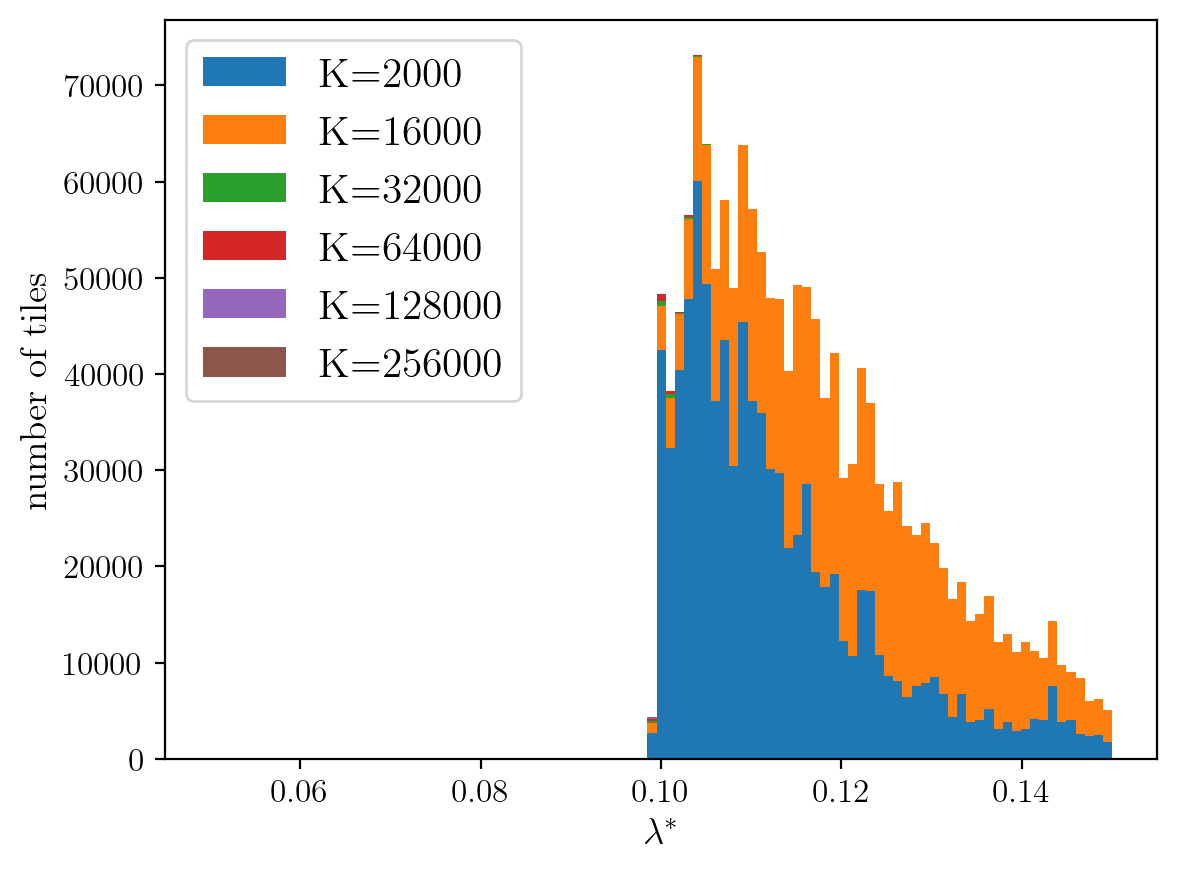

In [92]:
plt.hist(
    [bootstrap_cvs[sim_sizes == K, 0] for K in np.unique(sim_sizes)],
    stacked=True,
    bins=np.linspace(0.05, 0.15, 100),
    label=[f'K={K}' for K in np.unique(sim_sizes)],
)
plt.legend()
plt.xlabel('$\lambda^*$')
plt.ylabel('number of tiles')
plt.show()

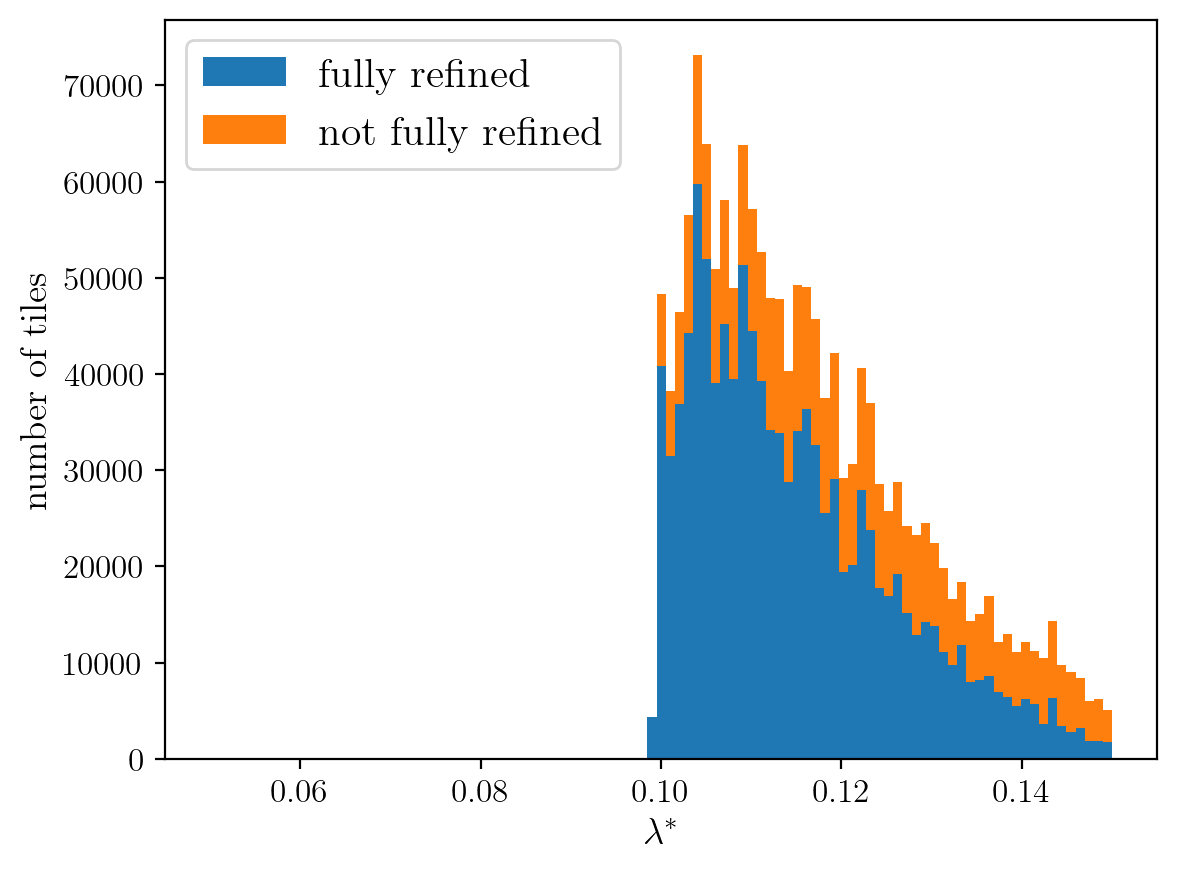

In [93]:
refinement_done = target_alpha - pointwise_target_alpha < target_grid_cost
plt.hist(
    [bootstrap_cvs[refinement_done,0 ], bootstrap_cvs[~refinement_done,0]],
    stacked=True,
    bins=np.linspace(0.05, 0.15, 100),
    label=['fully refined', 'not fully refined'],
)
plt.legend()
plt.xlabel('$\lambda^*$')
plt.ylabel('number of tiles')
plt.show()

52911


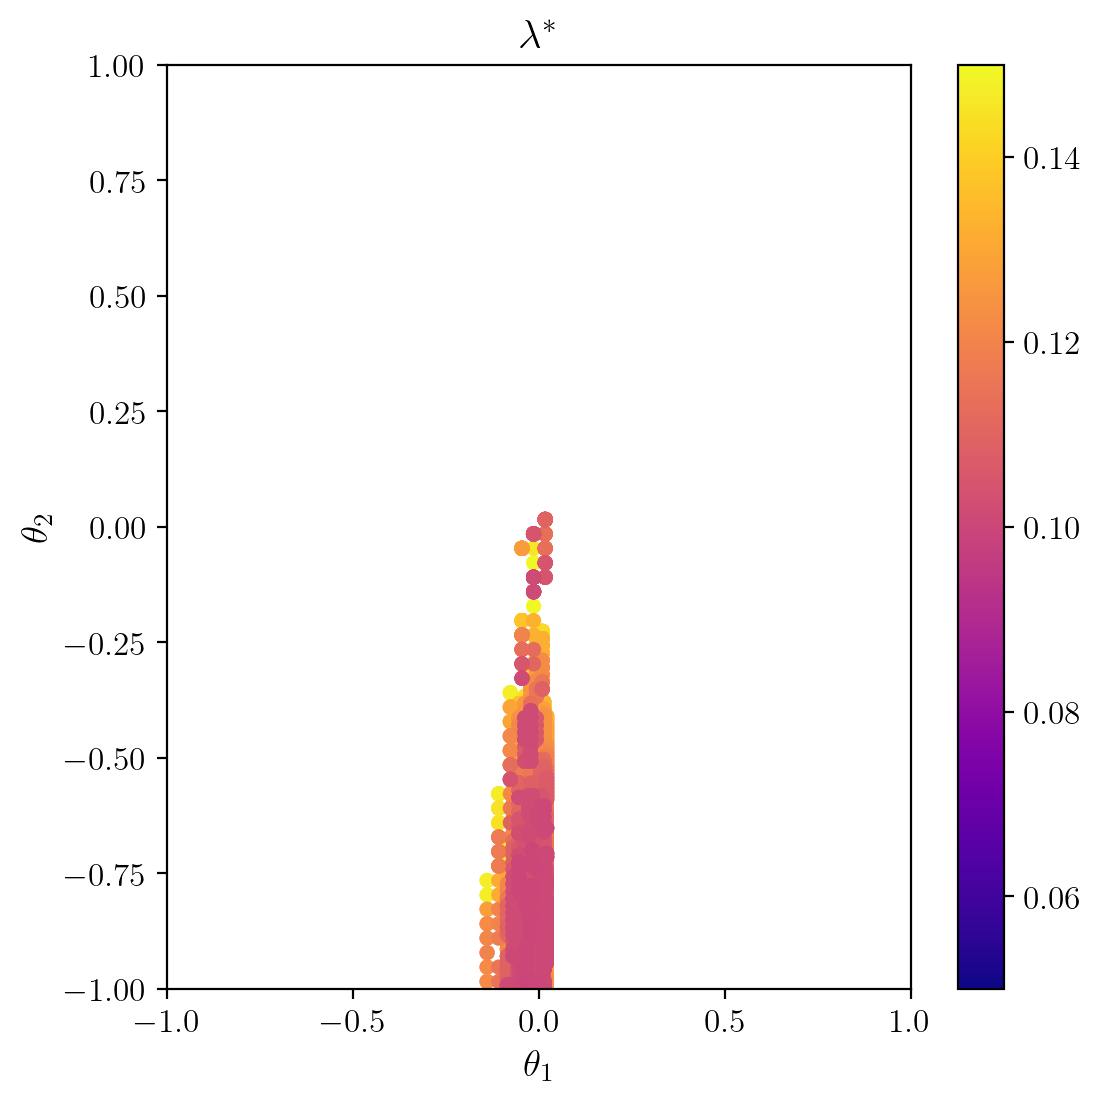

60152


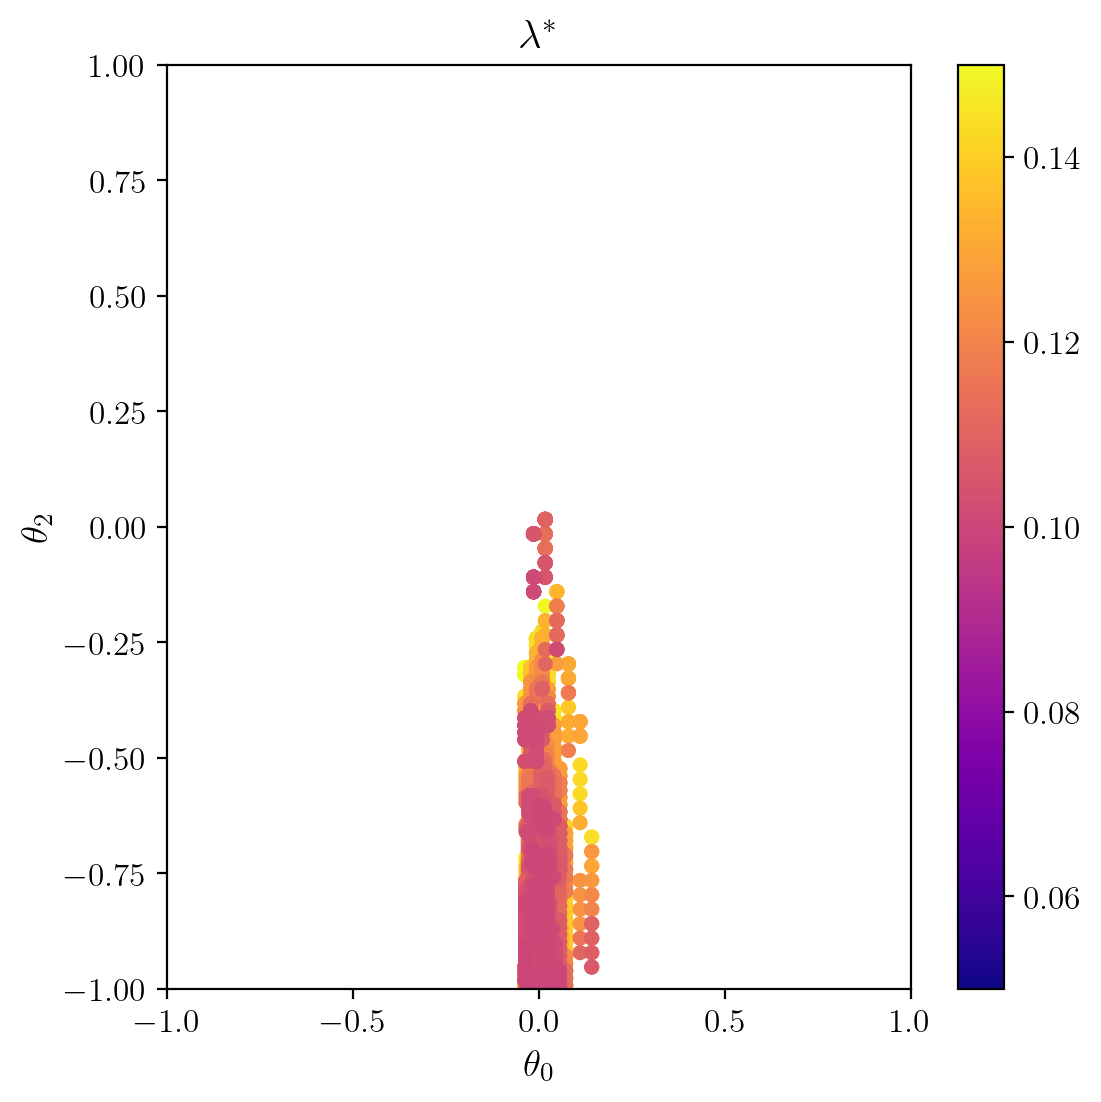

In [69]:
worst_tile_idx = np.argmin(bootstrap_cvs[:,0])
worst_tile = g.theta_tiles[worst_tile_idx]
# def pandemonium(field):
field = bootstrap_cvs[:,0]
# for unplot_set in [{0, 1}, {1, 2}]:
for unplot_set in [{0}, {1}]:
    plot = list(set(range(n_arms)) - unplot_set)
    unplot = list(unplot_set)
    axis_slice = np.all(np.abs(g.theta_tiles[:, unplot] - (-0.01)) < 0.03, axis=-1)
    select = np.where(axis_slice & (field < 0.15))[0]

    ordered_select = select[np.argsort(field[select])[::-1]]
    print(ordered_select.shape[0])

    plt.figure(figsize=(6, 6))
    plt.title(r"$\lambda^{*}$")
    plt.scatter(
        g.theta_tiles[ordered_select, plot[0]],
        g.theta_tiles[ordered_select, plot[1]],
        c=field[ordered_select],
        vmin=0.05,
        vmax=0.15,
        s=20,
    )
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.colorbar()
    plt.xlabel(f"$\\theta_{plot[0]}$")
    plt.ylabel(f"$\\theta_{plot[1]}$")
    plt.show()

In [43]:
ada_step_size = 1 * grid_batch_size
close_to_worst = np.zeros(g.n_tiles, dtype=bool)
# close_to_worst[np.random.choice(np.arange(g.n_tiles), size)] = True
# close_to_worst[np.argsort(bootstrap_cvs[:, 0] * (1 - (sim_sizes >= 16000)))[:ada_step_size]] = True
close_to_worst[np.where(sim_sizes == 256000)[0]] = True
bootstrap_min_cvs = np.min(bootstrap_cvs[:, 0:], axis=0)
cv_std = bootstrap_min_cvs.std()
bootstrap_typeI_sum = batched_many_rej(
    sim_sizes[close_to_worst],
    (np.tile(bootstrap_min_cvs[None, :], (np.sum(close_to_worst), 1)),
    g.theta_tiles[close_to_worst],
    g.null_truth[close_to_worst],),
    (unifs,),
    unifs_order
)
typeI_std = np.zeros(g.n_tiles)
typeI_std[close_to_worst] = (bootstrap_typeI_sum / sim_sizes[close_to_worst, None]).std(axis=1)
bootstrap_min_cvs

running for size 256000 with 32 tiles took 172.54376745224


array([0.09541287, 0.03189927, 0.0617875 , 0.0617875 , 0.04375319, 0.05925731, 0.04090066,
       0.05547158, 0.0617875 , 0.05019499, 0.05026214])

In [53]:
bootstrap_cvs[close_to_worst]

array([[0.09933095, 0.09873954, 0.09952766, 0.0972163 , 0.0992058 , 0.10051313, 0.09849644,
        0.10049215, 0.09936186, 0.10044983, 0.10173914],
       [0.09895011, 0.09859737, 0.09934005, 0.09719654, 0.09910179, 0.10024319, 0.09843415,
        0.10038505, 0.09904986, 0.10020976, 0.10143386],
       [0.09874047, 0.09854548, 0.09934567, 0.09697471, 0.0989966 , 0.10022179, 0.09834938,
        0.10024319, 0.0989966 , 0.10015938, 0.10116139],
       [0.09886928, 0.09856033, 0.09934828, 0.09697471, 0.09904942, 0.10022179, 0.09834938,
        0.10038505, 0.0989966 , 0.10020976, 0.10118144],
       [0.09933095, 0.09873954, 0.09952766, 0.0972163 , 0.0992058 , 0.10051313, 0.09849644,
        0.10049215, 0.09936186, 0.10044983, 0.10173914],
       [0.09895011, 0.09859737, 0.09934005, 0.09719654, 0.09910179, 0.10024319, 0.09843415,
        0.10038505, 0.09904986, 0.10020976, 0.10143386],
       [0.09874047, 0.09854548, 0.09934567, 0.09697471, 0.0989966 , 0.10022179, 0.09834938,
        0.1002

In [51]:
overall_cv

0.09541286543752213

In [50]:
np.where(sim_sizes == 128000)[0][:32]

array([263751, 263757, 263759, 263761, 263763, 263769, 263771, 263777, 263779, 263847, 263853,
       263855, 263857, 263859, 263865, 263867, 263873, 263875, 266237, 266239, 268309, 268311,
       268935, 268941, 268943, 268945, 268947, 268953, 268955, 268961, 268963, 269031])

In [44]:
bias = (bootstrap_typeI_sum[:,0] - bootstrap_typeI_sum[:, 1:].mean(axis=1)) / sim_sizes[close_to_worst]
std = bootstrap_typeI_sum[:, 1:].std(axis=1) / sim_sizes[close_to_worst]
bias, std

(array([0.01064219, 0.01065859, 0.01066602, 0.01066602, 0.01064219, 0.01065859, 0.01066602,
        0.01066602, 0.01064219, 0.01065859, 0.01066602, 0.01066602, 0.01064219, 0.01065859,
        0.01066602, 0.01066602, 0.0105207 , 0.01053828, 0.01054141, 0.01053086, 0.0105207 ,
        0.01053828, 0.01054141, 0.01053086, 0.0105207 , 0.01053828, 0.01054141, 0.01053086,
        0.0105207 , 0.01053828, 0.01054141, 0.01053086]),
 array([0.00260049, 0.00260566, 0.00260668, 0.00261096, 0.00260049, 0.00260566, 0.00260668,
        0.00261096, 0.00260049, 0.00260566, 0.00260668, 0.00261096, 0.00260049, 0.00260566,
        0.00260668, 0.00261096, 0.00260099, 0.00260819, 0.00260918, 0.00261611, 0.00260099,
        0.00260819, 0.00260918, 0.00261611, 0.00260099, 0.00260819, 0.00260918, 0.00261611,
        0.00260099, 0.00260819, 0.00260918, 0.00261611]))

In [44]:
key = jax.random.PRNGKey(0)
unifs = jax.random.uniform(key=key, shape=(np.max(sim_sizes),) + lei_obj.unifs_shape())
unifs_order = np.arange(0, unifs.shape[1])

batch_size = 2**4
idxs = np.where(sim_cvs == 0)[0][:batch_size]
overall_cv = 0
simv = jax.jit(
    jax.vmap(lts.sim, in_axes=(None, 0, None, None)), static_argnums=(0,)
)
tunev = jax.jit(jax.vmap(lts.tune, in_axes=(None, 0, 0, 0, None, None)), static_argnums=(0,))
rejv = jax.jit(
    jax.vmap(lts.rej, in_axes=(None, 0, 0, 0, None, None)), static_argnums=(0,)
)
batched_sim = lts.grouped_by_sim_size(lei_obj, simv, batch_size, n_out=2)
batched_rej = lts.grouped_by_sim_size(lei_obj, rejv, batch_size)
batched_tune = lts.grouped_by_sim_size(lei_obj, tunev, batch_size)

In [49]:
test_stats, best_arms = lts.simv(lei_obj, g.theta_tiles[idxs], unifs[:1000], unifs_order[:1000])

In [69]:
alpha = pointwise_target_alpha[idxs[0]]
cv_idx = jnp.maximum(
    jnp.floor((unifs.shape[0] + 1) * jnp.maximum(alpha, 0)).astype(int) - 1, 0
)
cv_idx

DeviceArray(23, dtype=int64)

In [6]:
sortedts = jnp.sort(test_stats[0])

NameError: name 'test_stats' is not defined

In [41]:
unifs.shape

(1000, 350, 3)

In [39]:
test_stats, best_arm = batched_sim(sim_sizes[idxs], [g.theta_tiles[idxs]], [unifs, unifs_order])

ValueError: shape mismatch: value array of shape (0,1000) could not be broadcast to indexing result of shape (16,1000)

In [ ]:
test_stats.shape

(1000,)

In [ ]:
typeI_sum = batched_sim(
    sim_sizes[idxs],
    np.full(idxs.shape[0], overall_cv),
    g.theta_tiles[idxs],
    g.null_truth[idxs],
    unifs,
    unifs_order,
)

In [ ]:

# import confirm.lewislib.batch as batch
# import confirm.mini_imprint.binomial as binomial
# batched_invert_bound = batch.batch_all_concat(
#     lambda *args: (binomial.invert_bound(*args),),
#     grid_batch_size,
#     in_axes=(None, 0, 0, None, None),
# )
# pta = batched_invert_bound(
#     target_alpha, g.theta_tiles[:1], g.vertices[:1], n_arm_samples, holderq
# )[0]
# pta